# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data was provided Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will check how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("number of rows in AZDIAS dataset :{}".format(azdias.shape[0]),"\n"
      "number of columns in AZDIAS :{}".format(azdias.shape[1]))

print("number of rows in Feature Summary :{}".format(feat_info.shape[0]),"\n"
      "number of columns in Feature Summary :{}".format(feat_info.shape[1]))


number of rows in AZDIAS dataset :891221 
number of columns in AZDIAS :85
number of rows in Feature Summary :85 
number of columns in Feature Summary :4


In [4]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help making cleaning decisions during this stage of the project. First of all, I will assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [7]:
num_nat_missing = azdias.isnull().sum().sum()
print("number of data points is naturally missing :{}".format(num_nat_missing))

number of data points is naturally missing :4896838


In [8]:
# Identify missing or unknown data values and convert them to NaNs.
for fi in range(azdias.shape[1]):
    missing_list = feat_info['missing_or_unknown'][fi][1:-1].split(',')
    if feat_info['missing_or_unknown'][fi] != '[]': # if missing value list is not empty
        for missing_val in missing_list:
            if missing_val.isnumeric() or missing_val.lstrip('-').isnumeric():
                missing_val = int(missing_val)
            azdias[feat_info['attribute'][fi]] = azdias[feat_info['attribute'][fi]].replace(missing_val, np.nan)
            

In [9]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [10]:
num_missing = azdias.isnull().sum().sum()
num_coded_missing = num_missing - num_nat_missing

print("number of data points is coded missing :{}".format(num_coded_missing))
print("number of total missing data :{}".format(num_missing))

number of data points is coded missing :3477091
number of total missing data :8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. 

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias.isnull().sum()
print(missing_col)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [12]:
# Investigate patterns in the amount of missing data in each column.
missing_col.sort_values(ascending=True,inplace=True)
missing_col

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [13]:
missing_col_per = missing_col/azdias.shape[0]*100
missing_col_per

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

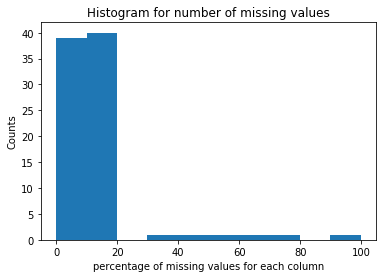

In [14]:
plt.hist(missing_col_per)
plt.xlabel('percentage of missing values for each column')
plt.ylabel('Counts')
plt.title('Histogram for number of missing values')
plt.show()

In [15]:
# Remove the outlier columns from the dataset. (other data
# engineering tasks such as re-encoding and imputation will be performed later.)
outlier_col = missing_col_per[missing_col_per > 20].index
azdias.drop(columns=outlier_col, axis="columns",inplace=True)

In [16]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

In total, there are 8373929 data points are missing or unknown from the dataset. Among them, 
4896838 data points are naturally missing and 3477091 data points are coded missing. 

By checking the histogram of percentage of missing data in each column, I found that most columns have missing data lower than 20%. Therefore, those with missing data higher than 20% were outliers and removed from the dataset. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset.I divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I checked if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.

In [17]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1)
missing_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

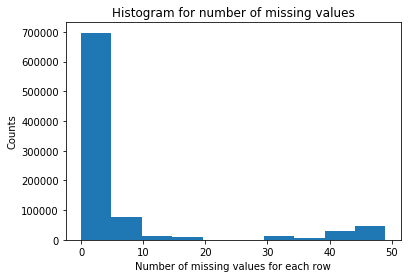

In [18]:
plt.hist(missing_row)
plt.xlabel('Number of missing values for each row')
plt.ylabel('Counts')
plt.title('Histogram for number of missing values')
plt.show()

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
boundary = 20

less_missing = azdias[missing_row<boundary]
more_missing =azdias[missing_row>=boundary]

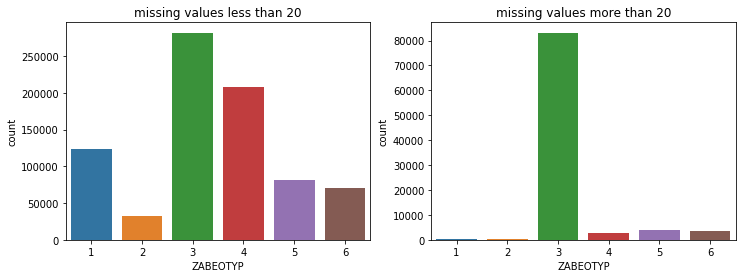

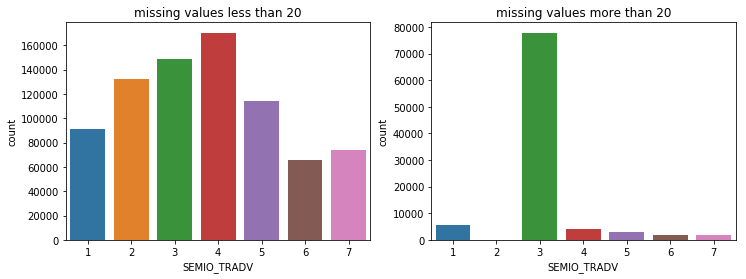

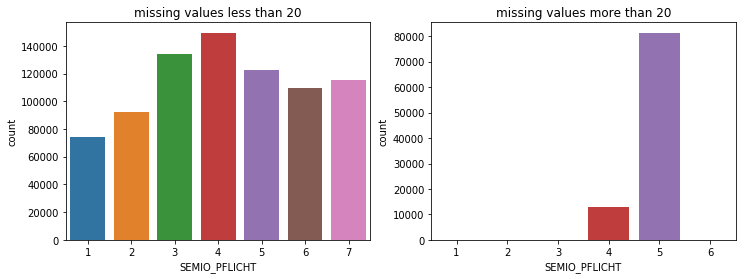

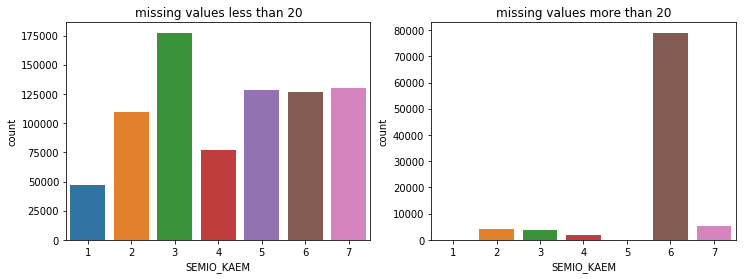

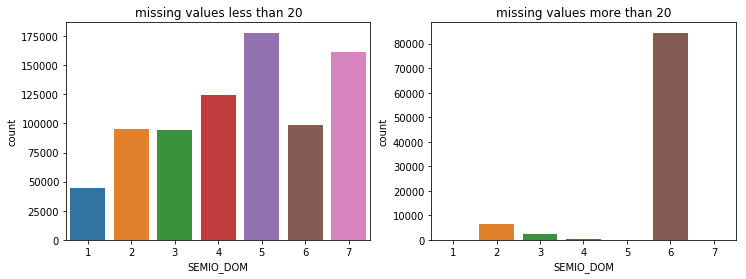

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
top5_col = missing_col[:5].index

def compare_plot(column):
    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(12)
    axs[0].set_title('missing values less than 20')
    sns.countplot(less_missing[column], ax=axs[0])
    axs[1].set_title('missing values more than 20')
    sns.countplot(more_missing[column], ax=axs[1])   

for column in top5_col:
    compare_plot(column)


#### Discussion 1.1.3: Assess Missing Data in Each Row

For rows, the number of missing values ranges from 0 to 49. From the Histogram for number of missing values, we found that the majority of rows has missing value less than 20. Therefore, we separate the data into rows with lots of missing values (more than 19) and rows with less missing values (less than 20). 
As we saw in the above figures, the data with less missing values show different pattern of distribution compared with data with lots of missing values. 

In [21]:
# continue with rows with less missing values

azdias_1 = azdias[missing_row<20]
azdias_1.shape

(797077, 79)

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [22]:
# How many features are there of each data type?
feat_info = feat_info[feat_info.attribute.isin(azdias_1.columns)]
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_var = feat_info[feat_info.type=="categorical"]
cat_binary = []
cat_multi = []
for col in cat_var.attribute:
    if azdias_1[col].nunique() == 2:
        cat_binary.append(col)
    else:
        cat_multi.append(col)
    print(col)
    print(azdias_1[col].unique())

ANREDE_KZ
[2 1]
CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP
[1 6 5 2 4 3]
GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE
[0 1]
LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ
[  1.   3.   2.  nan]
SHOPPER_TYP
[  3.   2.   1.   0.  nan]
SOHO_KZ
[ 1.  0.]
VERS_TYP
[  2.   1.  nan]
ZABEOTYP
[5 3 4 1 6 2]
GEBAEUDETYP
[ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ
['W' 'O']
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [24]:
# Re-encode binary categorical variable(s) to be kept in the analysis.
for col in cat_binary:
    if isinstance(azdias_1[col].unique()[0], str):
        azdias_1[col].replace({azdias_1[col].unique()[0]:0,azdias_1[col].unique()[1]:1},inplace=True)
    print(azdias_1[col].unique())
        

[2 1]
[0 1]
[ 1.  0.]
[  2.   1.  nan]
[0 1]


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [25]:
# drop features
azdias_1 = azdias_1.drop(columns=['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015'])
azdias_1.shape

(797077, 76)

In [26]:
for col in ['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015']:
    cat_multi.remove(col)

In [27]:
# Re-encode multiple categorical variable(s) to be kept in the analysis.
azdias_1 = pd.get_dummies(data=azdias_1,columns=cat_multi)    

In [28]:
azdias_1.shape

(797077, 175)

#### Discussion 1.2.1: Re-Encode Categorical Features

I dropped three features: 'LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015'. Because there are similar features with different scale.  
I re-encoded the binary categorical features with string values into numerical values. 
I used get_dummies function from pandas to re-encode the variables for multiple categorical features. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

In [29]:
mix_var = feat_info[feat_info.type=="mixed"]
mix_var

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [30]:
azdias_1["PRAEGENDE_JUGENDJAHRE"].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_rep = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
azdias_1["DECADE"] = azdias_1["PRAEGENDE_JUGENDJAHRE"].replace(decade_rep)
movement_rep = {1:1,2:2,3:1,4:2,5:1,6:2,7:2,8:1,9:2,10:1,11:2,12:1,13:2,14:1,15:2}
azdias_1["MOVEMENT"] = azdias_1["PRAEGENDE_JUGENDJAHRE"].replace(movement_rep)
azdias_1.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [32]:
azdias_1["CAMEO_INTL_2015"].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_1["WEALTH"] = azdias_1["CAMEO_INTL_2015"]
azdias_1["LIFE_STAGE"] = azdias_1["CAMEO_INTL_2015"]
azdias_1.drop("CAMEO_INTL_2015",axis=1,inplace=True)
for i in list(range(1,6)):
    for ii in list(range(1,6)):
        azdias_1["WEALTH"].replace(str(i*10+ii),int(i), inplace=True)
        azdias_1["LIFE_STAGE"].replace(str(i*10+ii),int(ii), inplace=True)

In [34]:
# drop "LP_LEBENSPHASE_FEIN" etc. features since it is a mixture of other exsit features
azdias_1.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_FEIN", "PLZ8_BAUMAX"],axis=1,inplace=True)


In [35]:
azdias_1.shape

(797077, 175)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are six mixed-value features. 
I drop three of them which is "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_FEIN", "PLZ8_BAUMAX", since they contain information that already exist in other non-mixed features.
The rest I kept. "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were broken into new variables.
Engineering steps:
1. create new variables for each mixed features
2. replace values the mixed-type in a new feature
3. drop the mixed feature from the dataset

#### Step 1.2.3: Complete Feature Selection

To be sure that the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.


In [36]:
azdias_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 175 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(43), int64(23), uint8(109)
memory usage: 490.3 MB


### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that one may need to perform the same cleaning steps on the customer demographics data. 
In this substep, I generate functions to execute the main feature selection, encoding, and re-engineering steps you performed above. 

In [38]:
def clean_data(df,feat_info, outlier_col):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for fi in range(df.shape[1]):
        missing_list = feat_info['missing_or_unknown'][fi][1:-1].split(',')
        if feat_info['missing_or_unknown'][fi] != '[]': # if missing value list is not empty
            for missing_val in missing_list:
                if missing_val.isnumeric() or missing_val.lstrip('-').isnumeric():
                    missing_val = int(missing_val)
                df[feat_info['attribute'][fi]] = df[feat_info['attribute'][fi]].replace(missing_val, np.nan)
  
    # remove selected columns and rows, ...
    df.drop(columns=outlier_col, axis="columns",inplace=True)
    
    missing_row = df.isnull().sum(axis=1)
    df = df[missing_row<20]
    # select, re-encode, and engineer column values.
    feat_info = feat_info[feat_info.attribute.isin(df.columns)]
    cat_var = feat_info[feat_info.type=="categorical"]
    cat_binary = []
    cat_multi = []
    for col in cat_var.attribute:
        if df[col].nunique() == 2:
            cat_binary.append(col)
        else:
            cat_multi.append(col)
    for col in cat_binary:
        if isinstance(df[col].unique()[0], str):
            df[col].replace({df[col].unique()[0]:0,df[col].unique()[1]:1},inplace=True)
    
    df.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015'],axis=1,inplace=True,errors='ignore')
         
    for col in ['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015']:
        if col in cat_multi:
            cat_multi.remove(col)
    df = pd.get_dummies(data=df,columns=cat_multi)  
    
    decade_rep = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    df["DECADE"] = df["PRAEGENDE_JUGENDJAHRE"]
    df["DECADE"].replace(decade_rep, inplace=True)
    movement_rep = {1:1,2:2,3:1,4:2,5:1,6:2,7:2,8:1,9:2,10:1,11:2,12:1,13:2,14:1,15:2}
    df["MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"]
    df["MOVEMENT"].replace(movement_rep, inplace=True)
    df.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True,errors='ignore')
    
    df["WEALTH"] = df["CAMEO_INTL_2015"]
    df["LIFE_STAGE"] = df["CAMEO_INTL_2015"]
    df.drop("CAMEO_INTL_2015",axis=1,inplace=True,errors='ignore')
    for i in list(range(1,6)):
        for ii in list(range(1,6)):
            df["WEALTH"].replace(str(i*10+ii),int(i), inplace=True)
            df["LIFE_STAGE"].replace(str(i*10+ii),int(ii), inplace=True)
    
    df.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_FEIN", "PLZ8_BAUMAX"],axis=1,inplace=True,errors='ignore')

    # Return the cleaned dataframe.
    return df
    

In [39]:
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info1 = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
azdias_test = clean_data(azdias_test,feat_info1, outlier_col)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
azdias_test.shape

(797077, 175)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before applying dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 
Starting from this part of the project, we can keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help navigating to all of the classes and functions that you'll need. In this substep, check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# check NaN values
azdias_1.isnull().sum().sum()

792675

In [44]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler, Imputer

imp= Imputer(missing_values='NaN', strategy='most_frequent')
data_imp = imp.fit_transform(azdias_1)
scaler = StandardScaler()
azdias_sc = scaler.fit_transform(data_imp)

In [45]:
azdias_sc = pd.DataFrame(azdias_sc, columns = azdias_1.columns.tolist())

In [46]:
azdias_sc.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.098802,-0.530654,1.175857,-1.249369
1,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.098802,1.884467,-0.869590,0.766691
2,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.267171,-0.530654,-1.551406,-0.577349
3,0.200733,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.010291,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.267171,-0.530654,0.494041,0.094671
4,-1.766173,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.010291,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-1.633144,-0.530654,1.175857,0.766691


### Discussion 2.1: Apply Feature Scaling

First, as I did in the previous section, I only kept data rows with no missing values. 
second, I apply StandardScale from sklean.preprocessing to scale each featureto mean 0 and SD 1. 

### Step 2.2: Perform Dimensionality Reduction

We are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on the findings, select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once the number of components to keep are choosen, make sure to re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_sc)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

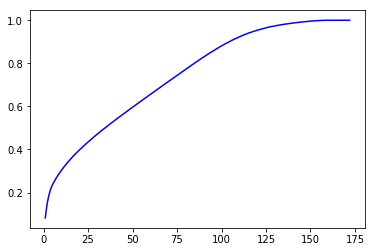

In [45]:
# Investigate the variance accounted for by each principal component.
values = pca.explained_variance_ratio_
base = list(range(1,len(pca.explained_variance_ratio_)+1))
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base, cumulative, c='blue')

In [48]:
from sklearn.decomposition import PCA

n_comp = len(cumulative[cumulative<0.8])
pca_n = PCA(n_components=n_comp)
data_pca = pca_n.fit_transform(azdias_sc)

In [49]:
print('Number of principal components are retained: ',n_comp)

Number of principal components are retained:  84


### Discussion 2.2: Perform Dimensionality Reduction

About 50% of the features already covered more than 80% of the explained variences. 
Therefore, for the next step, I choose to retain 85 principle components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- we should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df,pca,n):
    weights = pd.DataFrame(pca.components_, columns = df.columns.tolist())
    weights_n = weights.loc[n]
    weights_n.sort_values(ascending=False, inplace=True)
    return weights_n

print(PCA_weights(azdias_sc,pca_n,0))

PLZ8_ANTG3               0.187398
HH_EINKOMMEN_SCORE       0.186262
WEALTH                   0.181532
PLZ8_ANTG4               0.180399
ORTSGR_KLS9              0.162928
EWDICHTE                 0.160993
FINANZ_SPARER            0.146853
FINANZ_HAUSBAUER         0.145097
FINANZTYP_1              0.134342
LP_STATUS_FEIN_2.0       0.131156
KBA05_ANTG4              0.130993
PLZ8_ANTG2               0.129274
KBA05_ANTG3              0.119019
ANZ_HAUSHALTE_AKTIV      0.117387
LP_STATUS_FEIN_1.0       0.116965
ARBEIT                   0.116830
SEMIO_PFLICHT            0.112709
RELAT_AB                 0.111307
DECADE                   0.108993
SEMIO_REL                0.108480
SEMIO_RAT                0.094159
ZABEOTYP_5               0.090754
SEMIO_TRADV              0.087409
LP_FAMILIE_FEIN_1.0      0.084165
FINANZ_UNAUFFAELLIGER    0.081431
FINANZ_ANLEGER           0.079086
SEMIO_MAT                0.073372
GEBAEUDETYP_3.0          0.070747
SEMIO_FAM                0.069578
GFK_URLAUBERTY

In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(PCA_weights(azdias_sc,pca_n,1))

ALTERSKATEGORIE_GROB     0.221605
FINANZ_VORSORGER         0.207418
ZABEOTYP_3               0.198937
SEMIO_ERL                0.176871
SEMIO_LUST               0.156430
RETOURTYP_BK_S           0.153892
W_KEIT_KIND_HH           0.123539
LP_STATUS_FEIN_1.0       0.114855
FINANZ_HAUSBAUER         0.109126
CJT_GESAMTTYP_2.0        0.101608
FINANZTYP_5              0.100280
PLZ8_ANTG3               0.094090
EWDICHTE                 0.091930
PLZ8_ANTG4               0.091457
ORTSGR_KLS9              0.091334
WEALTH                   0.082283
FINANZTYP_2              0.079838
SEMIO_KRIT               0.078728
KBA05_ANTG4              0.072309
SHOPPER_TYP_3.0          0.071404
SEMIO_KAEM               0.069070
ARBEIT                   0.068549
CJT_GESAMTTYP_1.0        0.068286
LP_FAMILIE_FEIN_1.0      0.066693
PLZ8_ANTG2               0.066277
HH_EINKOMMEN_SCORE       0.065825
ANZ_HAUSHALTE_AKTIV      0.065286
RELAT_AB                 0.065187
FINANZTYP_6              0.063308
GFK_URLAUBERTY

In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(PCA_weights(azdias_sc,pca_n,2))


SEMIO_VERT               0.322518
SEMIO_FAM                0.260686
SEMIO_SOZ                0.258023
SEMIO_KULT               0.250966
FINANZTYP_5              0.138014
FINANZ_MINIMALIST        0.130118
SHOPPER_TYP_0.0          0.123757
ZABEOTYP_1               0.113811
SEMIO_REL                0.109717
SEMIO_MAT                0.087687
RETOURTYP_BK_S           0.078039
MOVEMENT                 0.066906
GREEN_AVANTGARDE         0.066906
ORTSGR_KLS9              0.062006
W_KEIT_KIND_HH           0.061502
EWDICHTE                 0.061479
SHOPPER_TYP_1.0          0.055343
FINANZ_VORSORGER         0.052570
ZABEOTYP_6               0.051200
LP_STATUS_FEIN_3.0       0.050669
PLZ8_ANTG3               0.048087
PLZ8_ANTG4               0.047621
LP_STATUS_FEIN_1.0       0.046437
LP_STATUS_FEIN_10.0      0.042547
PLZ8_ANTG2               0.035713
RELAT_AB                 0.034967
ARBEIT                   0.033763
GFK_URLAUBERTYP_4.0      0.029443
NATIONALITAET_KZ_2.0     0.028944
GEBAEUDETYP_3.

### Discussion 2.3: Interpret Principal Components

 Investigation of the first few principal components generated. 

1. the first principle component:<br>
PLZ8_ANTG3               0.187398; Number of 6-10 family houses in the PLZ8 region<br>
HH_EINKOMMEN_SCORE       0.186262; Estimated household net income <br>
WEALTH                   0.181532; Wealth<br>
PLZ8_ANTG4               0.180399; Number of 10+ family houses in the PLZ8 region <br>
KBA05_ANTG1             -0.184795; Number of 1-2 family houses in the microcell<br>
PLZ8_ANTG1              -0.187753; Number of 1-2 family houses in the PLZ8 region<br>
MOBI_REGIO              -0.193034; Movement patterns<br>
FINANZ_MINIMALIST       -0.209977; low financial interest<br>

Based on those top positive and negative values, we notice that the first principle component is related to household fixed assets: income, wealth, real estate. 

2. the second principle component: <br>
ALTERSKATEGORIE_GROB     0.221605; Estimated age based on given name analysis<br>
FINANZ_VORSORGER         0.207418; be prepared financial typology <br>
ZABEOTYP_3               0.198937; Energy consumption typology, fair supplied<br>
SEMIO_ERL                0.176871; event-oriented personality <br>
SEMIO_REL               -0.206402; religious perconality <br>
FINANZ_UNAUFFAELLIGER   -0.207946; inconspicuous financial typology <br>
FINANZ_SPARER           -0.211128; money-saver <br>
DECADE                  -0.219366; born decade <br>

Based on those top positive and negative values, we notice that the second principle component is related to individual characters:  age, financial typology and personality.

3. the third principle component: <br>
SEMIO_VERT               0.322518; dreamful personality  <br>
SEMIO_FAM                0.260686; family-minded personality <br>
SEMIO_SOZ                0.258023; socially-minded personality <br>
SEMIO_KULT               0.250966; cultural-minded personality <br>
SEMIO_KRIT              -0.268655; critical-minded personality <br>
SEMIO_DOM               -0.287353; dominant-minded personality <br>
SEMIO_KAEM              -0.318474; combative attitude personality <br>
ANREDE_KZ               -0.348284; Gender, 1_male, 2_female<br>

Based on those top positive and negative values, we notice that the third principle component is related to personality and gender. Especially the PC is positively corelated to dreamful, family-minded, socially-minded, cultural-minded personality and male gender.  


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. Check how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. We will test for cluster counts through at least 10 clusters to get the full picture, but we shouldn't need to test for a number of clusters above about 30.
- Once selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. 

In [51]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans 
cluster_n = list(range(5,30,5))
score = []
for i in cluster_n:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(data_pca)
    # compute the average within-cluster distances.
    score.append(np.abs(model.score(data_pca)))

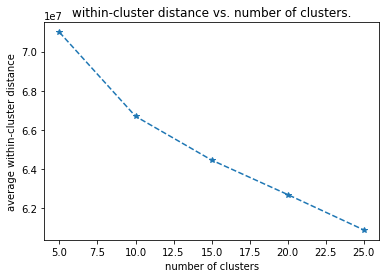

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
%matplotlib inline
plt.figure
plt.plot(cluster_n, score, linestyle='--', marker='*')
plt.xlabel('number of clusters')
plt.ylabel('average within-cluster distance')
plt.title("within-cluster distance vs. number of clusters.")
plt.show()

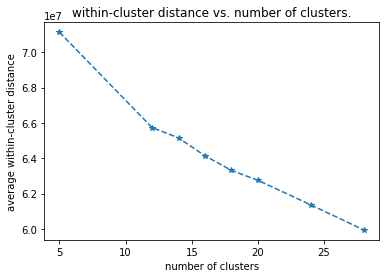

In [57]:
# another try
cluster_n = [5, 12, 14, 16, 18, 20, 24, 28]
score = []
for i in cluster_n:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(data_pca)
    # compute the average within-cluster distances.
    score.append(np.abs(model.score(data_pca)))

plt.figure
plt.plot(cluster_n, score, linestyle='--', marker='*')
plt.xlabel('number of clusters')
plt.ylabel('average within-cluster distance')
plt.title("within-cluster distance vs. number of clusters.")
plt.show()

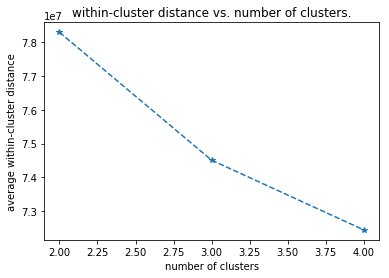

In [64]:
cluster_n1 = [2, 3, 4]
score1 = []
for i in cluster_n1:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(data_pca)
    # compute the average within-cluster distances.
    score1.append(np.abs(model.score(data_pca)))
    
#cluster_n = cluster_n1.append(cluster_n)
#score = score1.append(score)

plt.figure
plt.plot(cluster_n1, score1, linestyle='--', marker='*')
plt.xlabel('number of clusters')
plt.ylabel('average within-cluster distance')
plt.title("within-cluster distance vs. number of clusters.")
plt.show()

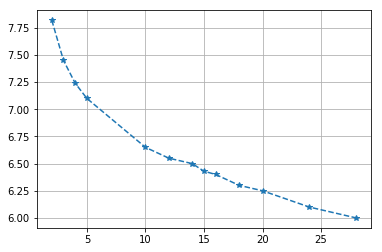

In [66]:
K = [2, 3, 4, 5, 10, 12, 14, 15, 16, 18, 20, 24, 28]
D = [7.82, 7.45, 7.24, 7.1, 6.65, 6.55, 6.5, 6.43, 6.4, 6.3, 6.25, 6.1, 6.0]
plt.plot(K, D, linestyle='--', marker='*')
plt.grid()
plt.show()

In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans 
K_selected = 10
kmeans = KMeans(n_clusters=K_selected)
model = kmeans.fit(data_pca)
data_pred = model.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

As the number of clusters increases, the average within-cluster distance decreases. 
I start with a list of K range from 5 to 30 with a step of 5, to get a rough look of the relationship between K and within-cluster distance. The plot looks like a arm. It drop fast for low K and slower when K increases. <br>
The "elbow" on the arm is the value of k that is the best. To get a fine look of this relationship, I redo the plot with smaller steps.  
Then I choose the "elbow" point to be 10.


### Step 3.2: Apply All Steps to the Customer Data

Now, it's time to see how the customer data maps on to those clusters. We're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function created earlier. 
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [55]:
customers.shape

(191652, 85)

In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# preprocessing
customers_processed = clean_data(customers,feat_info,outlier_col)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [57]:
print(customers_processed.isnull().sum().sum())
print(customers_processed.shape)
print(outlier_col)

111709
(141590, 174)
Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')


In [58]:
list(set(azdias_1)-set(customers_processed))

['GEBAEUDETYP_5.0']

In [60]:
customers_processed['GEBAEUDETYP_4.0'].unique()

array([0, 1], dtype=uint64)

In [61]:
customers_processed['GEBAEUDETYP_5.0'] = customers_processed['GEBAEUDETYP_4.0']
customers_processed['GEBAEUDETYP_5.0'].replace(1,0,inplace=True)

In [62]:
# scaling
customers_imp = imp.transform(customers_processed)
customers_sc = scaler.transform(customers_imp)
customers_sc = pd.DataFrame(customers_sc, columns = customers_processed.columns.tolist())
# feature transformation
customers_pca = pca_n.transform(customers_sc)
# clustering
customers_pred = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

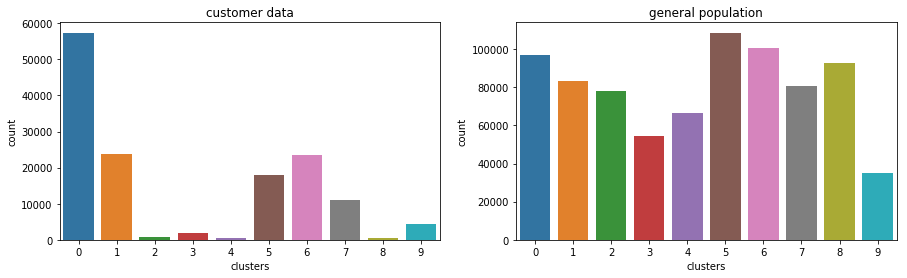

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
sns.countplot(customers_pred,ax=ax1)
ax1.set_title('customer data')
ax1.set_xlabel('clusters')
sns.countplot(data_pred,ax=ax2)
ax2.set_title('general population')
ax2.set_xlabel('clusters')
plt.show()

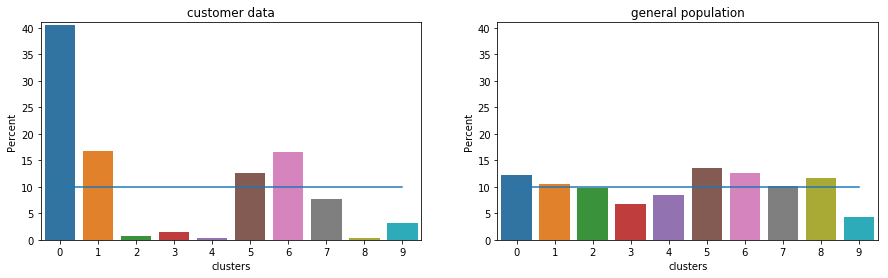

In [68]:
# plot proportion 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
df1 = pd.DataFrame(customers_pred,columns=['clusters'])
sns.barplot(x="clusters", y="clusters", data=df1, estimator=lambda x: len(x) / len(df1) * 100,ax=ax1)
ax1.set(ylabel="Percent")
ax1.set_title('customer data')
ax1.set_ylim([0,41])
ax1.plot([0,9],[10,10],linestyle='-')
df2 = pd.DataFrame(data_pred,columns=['clusters'])
sns.barplot(x="clusters", y="clusters", data=df2, estimator=lambda x: len(x) / len(df2) * 100,ax=ax2)
ax2.set(ylabel="Percent")
ax2.set_title('general population')
ax2.set_ylim([0,41])
ax2.plot([0,9],[10,10],linestyle='-')

In [69]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_n1 = [0,1,6]
pca_feature = ['high_fixed_assets','old_prepared','male_FSCminded'] # features for the first 3 PC
for i in cluster_n1:
    print(model.cluster_centers_[i][:3])

[-4.2820511   0.6905871   0.76649178]
[-3.59290863 -0.06589233  1.59360487]
[ 1.63949165  4.53440165 -1.69444316]


In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_n2 = [2,3,4,8]
for i in cluster_n2:
    print(model.cluster_centers_[i][:3])
print(pca_feature)

[-0.21397167 -3.56719367 -2.88650179]
[-0.91802669 -4.97204273  2.57892758]
[ 4.71124431 -2.31939477  2.75184292]
[ 5.04440452 -1.36147747 -2.37666921]
['high_fixed_assets', 'old_prepared', 'male_FSCminded']


In [74]:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca_n.inverse_transform(model.cluster_centers_)), columns=customers_processed.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
0,3.366457,1.493546,4.530389,1.582840,4.293299,1.749908,2.061209,2.201430,0.998740,2.078279,...,0.005637,0.003095,0.004479,0.004934,0.007367,-0.002058,3.515662,1.998740,2.006111,3.656974
1,3.274828,1.109884,4.504057,1.725976,4.264812,2.260088,1.755494,2.284091,0.019738,2.313313,...,0.003470,0.007273,0.005244,0.002338,0.000121,0.001128,3.579897,1.019738,2.537010,3.234094
2,1.861332,1.963843,2.090216,4.011479,2.296843,4.446836,3.962881,3.043150,0.166782,2.357744,...,0.004984,0.005220,0.006844,0.004583,0.012023,-0.000309,5.683690,1.166782,2.541304,3.208754
3,1.857311,0.963381,3.108927,4.013754,2.117221,3.795355,4.071110,2.170307,0.357341,2.227768,...,0.009736,0.012814,0.005659,0.009643,0.001813,0.000503,5.707885,1.357341,2.485229,3.279485
4,1.928481,0.973333,1.879450,4.410397,1.971855,3.567764,3.835355,3.607071,0.096298,2.366213,...,0.021036,0.063734,0.096202,0.085677,0.076916,0.002957,5.775639,1.096298,4.396416,1.981771
5,3.251699,1.057032,3.289398,1.909970,4.273067,1.552024,1.709144,3.580381,0.099269,2.354444,...,0.047484,0.031367,0.070007,0.064304,0.075996,0.014857,3.533875,1.099269,4.240934,2.384449
6,3.551882,1.958820,2.576506,1.828229,4.304214,2.108746,1.701929,4.201427,0.072615,2.084186,...,0.066382,0.039855,0.044634,0.036853,0.053087,0.036034,3.402336,1.072615,4.253775,2.717093
7,3.558120,1.922700,3.750366,1.611074,4.295194,2.671390,1.744694,3.038920,0.038195,2.050258,...,0.001435,0.011082,0.000521,0.007010,0.001823,0.005815,3.415423,1.038195,2.616509,3.257304
8,1.804859,1.981186,1.116713,4.417150,2.224189,4.315232,3.776587,4.326701,0.041469,2.345175,...,0.025043,0.063845,0.080968,0.068684,0.086190,0.004354,5.725761,1.041469,4.326886,2.057908
9,2.562999,1.543792,4.094706,3.151832,2.549509,3.370297,3.900871,0.736120,0.358522,2.185583,...,0.003843,0.001531,-0.002909,0.002862,-0.000730,0.004519,5.381605,1.358522,2.214084,3.074387


In [76]:
# HH_EINKOMMEN_SCORE: Estimated household net income
# MOBI_REGIO: Movement patterns
# FINANZ_MINIMALIST: low financial interest
# ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
# ZABEOTYP: Energy consumption typology, fair supplied
# SEMIO_REL: religious perconality
# SEMIO_VERT: dreamful personality
# SEMIO_KAEM: combative attitude personality
# ANREDE_KZ: Gender, 1_male, 2_female

feature2u = ['HH_EINKOMMEN_SCORE','MOBI_REGIO','FINANZ_MINIMALIST','ALTERSKATEGORIE_GROB',
               'ZABEOTYP_3','SEMIO_REL','SEMIO_VERT','SEMIO_KAEM','ANREDE_KZ']
import math              
def plot_cluster_demographics(k, data_pca, data_pred, feature2u):
    feat_K = scaler.inverse_transform(pca_n.inverse_transform(data_pca[data_pred == k]))

    feat_K = pd.DataFrame(np.round(feat_K), columns = customers_processed.columns)
    
    fig, axs = plt.subplots(math.ceil(len(feature2u)/3),3, figsize=(18,8))
    fig.set_figheight(13)
    for i in list(range(len(feature2u))):
        sns.countplot(feat_K[feature2u[i]], ax = axs[i//3,i%3], color='c')
    return feat_K 

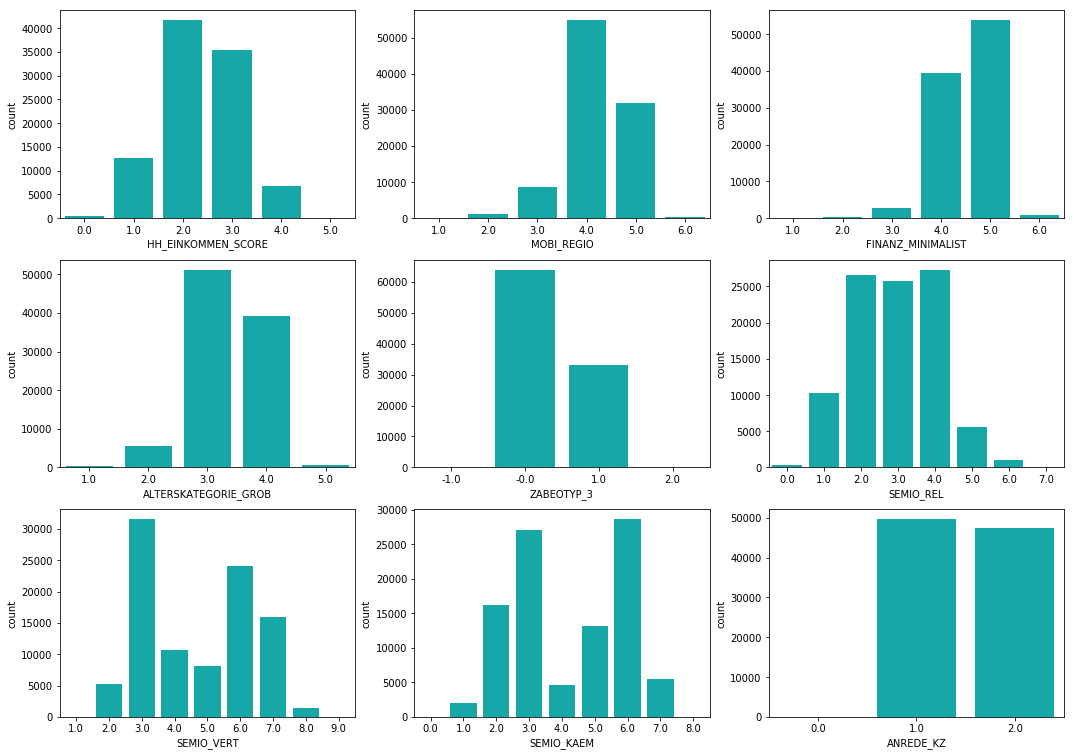

In [77]:
# check cluster 0, a overrepresented cluster in customers
k = 0
feat_K = plot_cluster_demographics(k, data_pca, data_pred, feature2u)

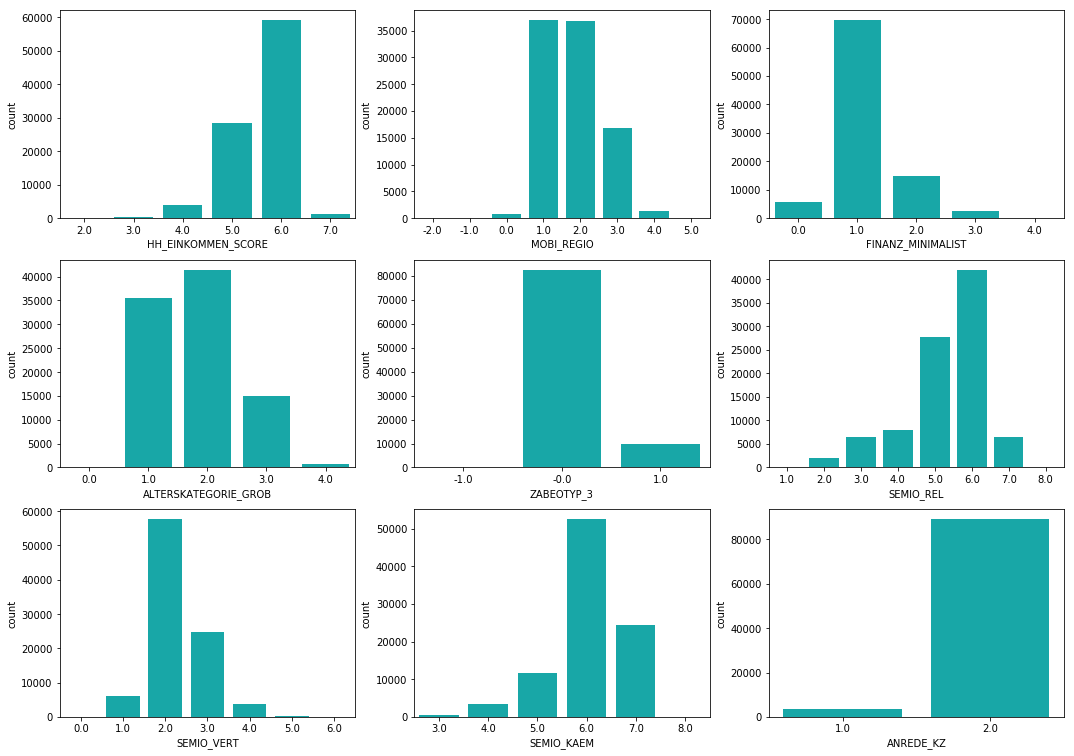

In [78]:
# check cluster 8, a underrepresented cluster in customers
k = 8
feat_K = plot_cluster_demographics(k, data_pca, data_pred, feature2u)

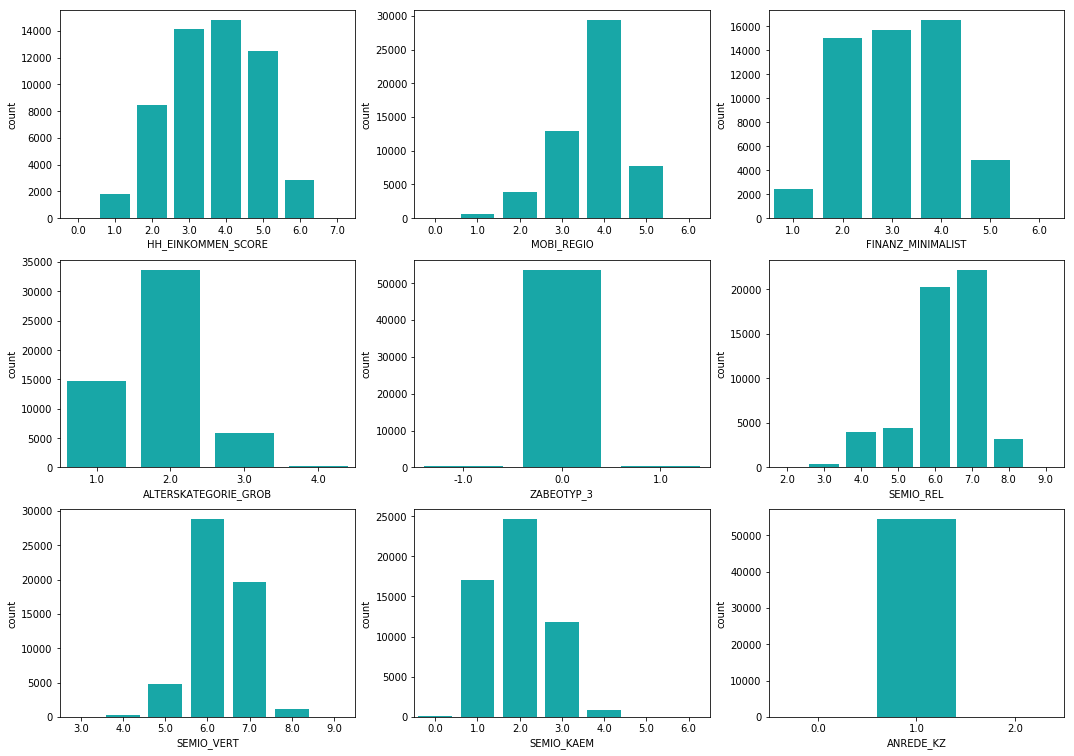

In [80]:
# check cluster 3, a underrepresented cluster in customers
k = 3
feat_K = plot_cluster_demographics(k, data_pca, data_pred, feature2u)

### Discussion 3.3: Compare Customer Data to Demographics Data

We observed that cluster 0, 1 and 6 are overrepresented in the customer data compared to the general population. Cluster 2, 3, 4 and 8 are underrepresented in the customer data compared to general population. 

After checking the some features of cluster 4 and 0, we found that people in Cluster 0 has the following feature: high-income, with very low movement, high financial interest, most of them above 46 years old, prefer fair supplied enegry, average to high affinity of religious, bipolar distribution of dreamfulness and combative attitude, equally distributed gender. <br>

and Cluster 8 has the following feature: low income, high movement, low financial interest, relatively younger (below 45), low affinity of religious, very dreamful, low combative attitude, female. <br>

I also check another underrepresented cluster Nr. 3. Compared to cluster 8, people in this cluster are male, not dreamful, very combative attitude.